In [3]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [4]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [5]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [44]:
VERSION  = "NB_EXP_013"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256

TRAIN_AUG = A.Compose([
    A.Resize(SZ, SZ),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75), 
])

CROP_PCT = 0.875
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

In [16]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [17]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [18]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [38]:
def get_dls(fold:int, size:int, bs:int, **kwargs):
    
    aug_tfm = AlbumentationsTransform(TRAIN_AUG, VALID_AUG)
    item_tfms = [aug_tfm, ToTensor]
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

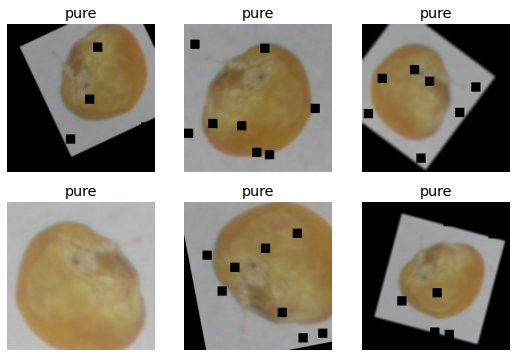

In [28]:
dls = get_dls(0, size=SZ, bs=BS)
dls.show_batch(max_n=6, unique=True)

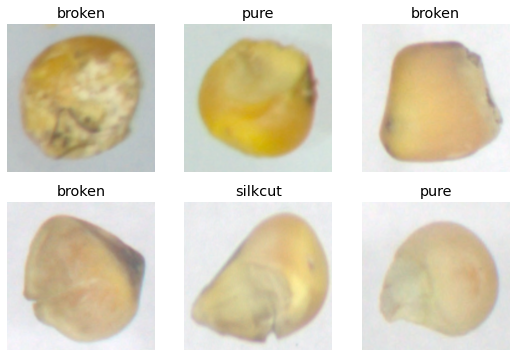

In [29]:
dls.valid.show_batch(max_n=6)

In [34]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [37]:
# set_seed(42);set_fast_norm()

# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
                           
#     dls = get_dls(0, size=SZ, bs=BS)
    
#     learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
#                            loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
#                            splitter=partial(timm_split, cut=-3)).to_fp16()
    
#     print(learn.lr_find(suggest_funcs=(valley, slide)))

In [36]:
n_epo = 15; base_lr = 2e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_augs_albu_mixup_ft"
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_012_convnext_tiny_256_bs32_epo15_augs_albu_mixup_ft


In [39]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
        
            dls = get_dls(fold_idx, size=SZ, bs=BS)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=partial(timm_split, cut=-3)).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None), MixUp(alpha=0.4)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.321410,0.819254,0.675393,00:30


Better model found at epoch 0 with accuracy value: 0.6753926873207092.


epoch,train_loss,valid_loss,accuracy,time
0,0.972231,0.656894,0.738569,00:41
1,0.891142,0.613253,0.748691,00:41
2,0.837122,0.588267,0.761257,00:41
3,0.843598,0.591826,0.758115,00:41
4,0.813581,0.611718,0.757417,00:41
5,0.798648,0.550020,0.776963,00:41
6,0.752983,0.578915,0.767539,00:41
7,0.735633,0.596787,0.756719,00:41
8,0.737723,0.514030,0.783246,00:41
9,0.714397,0.500848,0.795812,00:41


Better model found at epoch 0 with accuracy value: 0.7385689616203308.
Better model found at epoch 1 with accuracy value: 0.7486910820007324.
Better model found at epoch 2 with accuracy value: 0.7612565159797668.
Better model found at epoch 5 with accuracy value: 0.7769633531570435.
Better model found at epoch 8 with accuracy value: 0.7832460999488831.
Better model found at epoch 9 with accuracy value: 0.7958115339279175.
Better model found at epoch 10 with accuracy value: 0.8006981015205383.
Better model found at epoch 11 with accuracy value: 0.801047146320343.
Better model found at epoch 12 with accuracy value: 0.8013961315155029.
Better model found at epoch 13 with accuracy value: 0.8041884899139404.
CPU: 278/88/3588 MB | GPU: 448/2484/2307 MB | Time 0:11:11.676 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.319181,0.888073,0.634555,00:30


Better model found at epoch 0 with accuracy value: 0.6345549821853638.


epoch,train_loss,valid_loss,accuracy,time
0,1.001691,0.652871,0.740314,00:41
1,0.906606,0.625058,0.751832,00:41
2,0.865562,0.610049,0.764049,00:41
3,0.835759,0.572892,0.774171,00:41
4,0.828254,0.617855,0.752531,00:41
5,0.787854,0.568550,0.760908,00:41
6,0.780993,0.553601,0.779407,00:41
7,0.749353,0.528882,0.785340,00:41
8,0.767351,0.523194,0.787784,00:41
9,0.723928,0.556793,0.775567,00:41


Better model found at epoch 0 with accuracy value: 0.7403141260147095.
Better model found at epoch 1 with accuracy value: 0.7518324851989746.
Better model found at epoch 2 with accuracy value: 0.7640488743782043.
Better model found at epoch 3 with accuracy value: 0.7741710543632507.
Better model found at epoch 6 with accuracy value: 0.7794066071510315.
Better model found at epoch 7 with accuracy value: 0.7853403091430664.
Better model found at epoch 8 with accuracy value: 0.7877836227416992.
Better model found at epoch 10 with accuracy value: 0.8006981015205383.
Better model found at epoch 11 with accuracy value: 0.802443265914917.
Better model found at epoch 12 with accuracy value: 0.8104711771011353.
Better model found at epoch 13 with accuracy value: 0.8108202219009399.
CPU: 1/90/3589 MB | GPU: 98/2712/2405 MB | Time 0:11:16.021 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.289102,0.887603,0.649791,00:30


Better model found at epoch 0 with accuracy value: 0.6497905254364014.


epoch,train_loss,valid_loss,accuracy,time
0,0.982652,0.670493,0.732542,00:41
1,0.909953,0.629097,0.749651,00:41
2,0.842166,0.616784,0.751397,00:41
3,0.829737,0.697168,0.708799,00:41
4,0.815406,0.591420,0.758380,00:41
5,0.779629,0.559663,0.776885,00:41
6,0.765243,0.548529,0.778631,00:41
7,0.748296,0.580421,0.776885,00:41
8,0.750718,0.520373,0.790503,00:41
9,0.705943,0.536074,0.788408,00:41


Better model found at epoch 0 with accuracy value: 0.7325419187545776.
Better model found at epoch 1 with accuracy value: 0.7496508359909058.
Better model found at epoch 2 with accuracy value: 0.751396656036377.
Better model found at epoch 4 with accuracy value: 0.7583798766136169.
Better model found at epoch 5 with accuracy value: 0.776885449886322.
Better model found at epoch 6 with accuracy value: 0.7786312699317932.
Better model found at epoch 8 with accuracy value: 0.7905027866363525.
Better model found at epoch 10 with accuracy value: 0.7929469347000122.
Better model found at epoch 11 with accuracy value: 0.8016759753227234.
Better model found at epoch 12 with accuracy value: 0.8044692873954773.
Better model found at epoch 13 with accuracy value: 0.8090083599090576.
CPU: 49/90/3639 MB | GPU: 122/2598/2527 MB | Time 0:11:25.895 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.299014,0.855960,0.656425,00:30


Better model found at epoch 0 with accuracy value: 0.6564245820045471.


epoch,train_loss,valid_loss,accuracy,time
0,0.998780,0.664118,0.729050,00:41
1,0.932954,0.644508,0.750000,00:41
2,0.852387,0.584558,0.766760,00:41
3,0.851463,0.661744,0.725209,00:41
4,0.818545,0.570917,0.773045,00:41
5,0.786162,0.573859,0.778282,00:41
6,0.785244,0.558518,0.775140,00:41
7,0.762176,0.546649,0.778980,00:41
8,0.729856,0.490482,0.808310,00:41
9,0.726245,0.512207,0.798533,00:41


Better model found at epoch 0 with accuracy value: 0.7290502786636353.
Better model found at epoch 1 with accuracy value: 0.75.
Better model found at epoch 2 with accuracy value: 0.7667597532272339.
Better model found at epoch 4 with accuracy value: 0.7730447053909302.
Better model found at epoch 5 with accuracy value: 0.778282105922699.
Better model found at epoch 7 with accuracy value: 0.7789804339408875.
Better model found at epoch 8 with accuracy value: 0.8083100318908691.
Better model found at epoch 11 with accuracy value: 0.8121508359909058.
Better model found at epoch 12 with accuracy value: 0.8152933120727539.
Better model found at epoch 13 with accuracy value: 0.8163408041000366.
CPU: -46/96/3592 MB | GPU: 80/2542/2607 MB | Time 0:11:16.003 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.261191,0.816869,0.670391,00:30


Better model found at epoch 0 with accuracy value: 0.6703910827636719.


epoch,train_loss,valid_loss,accuracy,time
0,1.000286,0.667892,0.722416,00:41
1,0.894498,0.580397,0.766061,00:41
2,0.852723,0.598796,0.762221,00:41
3,0.824042,0.603450,0.758729,00:41
4,0.838403,0.580669,0.763617,00:41
5,0.790744,0.576491,0.776187,00:41
6,0.778289,0.528102,0.792249,00:41
7,0.763839,0.502513,0.799930,00:41
8,0.753542,0.479873,0.807263,00:41
9,0.724787,0.493504,0.800978,00:41


Better model found at epoch 0 with accuracy value: 0.7224162220954895.
Better model found at epoch 1 with accuracy value: 0.7660614252090454.
Better model found at epoch 5 with accuracy value: 0.7761871218681335.
Better model found at epoch 6 with accuracy value: 0.7922486066818237.
Better model found at epoch 7 with accuracy value: 0.7999301552772522.
Better model found at epoch 8 with accuracy value: 0.8072625994682312.
Better model found at epoch 11 with accuracy value: 0.8125.
Better model found at epoch 12 with accuracy value: 0.8145949840545654.
Better model found at epoch 14 with accuracy value: 0.8152933120727539.
CPU: 1/87/3593 MB | GPU: 48/2456/2655 MB | Time 0:11:13.613 | (Consumed/Peaked/Used Total)


In [41]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.81082, 0.81082, 0.81355, 0.81494, 0.81809]
Avg: 0.81364
Std: 0.00273


In [50]:
pattern = 'NB_EXP_012_convnext_tiny_256_bs32_epo15_augs_albu_mixup_ft_CV_' + '{fold:02d}'
folds_val_score = []

CROP_PCT = 0.950
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        aug_tfm = AlbumentationsTransform(None, VALID_AUG)
        item_tfms = [aug_tfm, ToTensor]
        batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
        
        tst_dl = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        tst_dl_1 = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        tst_dl_2 = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print(f"============ Run summary : ( crop@{CROP_PCT} ) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary : ( crop@0.95 ) ============
folds score:  [0.81117, 0.81326, 0.81355, 0.82018, 0.81913]
Avg: 0.81546
Std: 0.00354


In [51]:
pattern = 'NB_EXP_012_convnext_tiny_256_bs32_epo15_augs_albu_mixup_ft_CV_' + '{fold:02d}'
folds_val_score = []

CROP_PCT = 1
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        aug_tfm = AlbumentationsTransform(None, VALID_AUG)
        item_tfms = [aug_tfm, ToTensor]
        batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
        
        tst_dl = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        tst_dl_1 = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        tst_dl_2 = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print(f"============ Run summary : ( crop@{CROP_PCT} ) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary : ( crop@1 ) ============
folds score:  [0.81082, 0.81047, 0.81494, 0.82228, 0.81913]
Avg: 0.81553
Std: 0.00462


In [52]:
pattern = 'NB_EXP_012_convnext_tiny_256_bs32_epo15_augs_albu_mixup_ft_CV_' + '{fold:02d}'
folds_val_score = []

CROP_PCT = 0.960
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        aug_tfm = AlbumentationsTransform(None, VALID_AUG)
        item_tfms = [aug_tfm, ToTensor]
        batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
        
        tst_dl = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        tst_dl_1 = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        tst_dl_2 = dls.valid.new(after_item=item_tfms, after_batch=batch_tfms)
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print(f"============ Run summary : ( crop@{CROP_PCT} ) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary : ( crop@0.96 ) ============
folds score:  [0.81047, 0.81361, 0.81669, 0.82018, 0.81634]
Avg: 0.81546
Std: 0.00325
